## Background
Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Dermoscopy is a skin imaging modality that has demonstrated improvement for diagnosis of skin cancer compared to unaided visual inspection. However, clinicians should receive adequate training for those improvements to be realized. In order to make expertise more widely available, the International Skin Imaging Collaboration (ISIC) has developed the ISIC Archive, an international repository of dermoscopic images, for both the purposes of clinical training, and for supporting technical research toward automated algorithmic analysis by hosting the ISIC Challenges.

## Task
The goal for ISIC 2019 is classify dermoscopic images among nine different diagnostic categories:

1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
9. None of the others

25,331 images are available for training across 8 different categories.

More information regarding the challenge can be found [here](https://challenge2019.isic-archive.com/)

In [1]:
import tensorflow as tf
import keras

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/tensorf

In [2]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Image 
from PIL import Image 

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# Import various componenets for model building
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Import the backend
from keras import backend as K

# Other 
import shutil
import itertools

In [3]:
# Import data 
train = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ISIC_2019_Training_Metadata.csv')
test = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ISIC_2019_Test_Metadata.csv')
diagnoses = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ISIC_2019_Training_GroundTruth.csv')

In [4]:
train.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
image                  25331 non-null object
age_approx             24894 non-null float64
anatom_site_general    22700 non-null object
lesion_id              23247 non-null object
sex                    24947 non-null object
dtypes: float64(1), object(4)
memory usage: 989.6+ KB


In [6]:
diagnoses.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
image    25331 non-null object
MEL      25331 non-null float64
NV       25331 non-null float64
BCC      25331 non-null float64
AK       25331 non-null float64
BKL      25331 non-null float64
DF       25331 non-null float64
VASC     25331 non-null float64
SCC      25331 non-null float64
UNK      25331 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB


## Merge Diagnoses and Train tables 

We will merge the diagnoses and train tables so each image corresponds to their respective cell type. 

In [8]:
# Create df of cell types 
cell_type = pd.DataFrame([x for x in np.where(diagnoses == 1, diagnoses.columns,'').flatten().tolist() if len(x) > 0], columns=(['cell_type']))
cell_type.head()

,cell_type
0,NV
1,NV
2,MEL
3,NV
4,MEL


In [9]:
# Merge train and cell_type
raw_df = pd.concat([train, cell_type], axis=1, join='inner')
raw_df.head()

,image,age_approx,anatom_site_general,lesion_id,sex,cell_type
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


## Missing data
Although we will only use images as inputs for modeling, we will impute missing metadata for exploratory purposes. 


In [10]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
missing_values_table(raw_df)

Your selected dataframe has 6 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
anatom_site_general,2631,10.4
lesion_id,2084,8.2
age_approx,437,1.7
sex,384,1.5


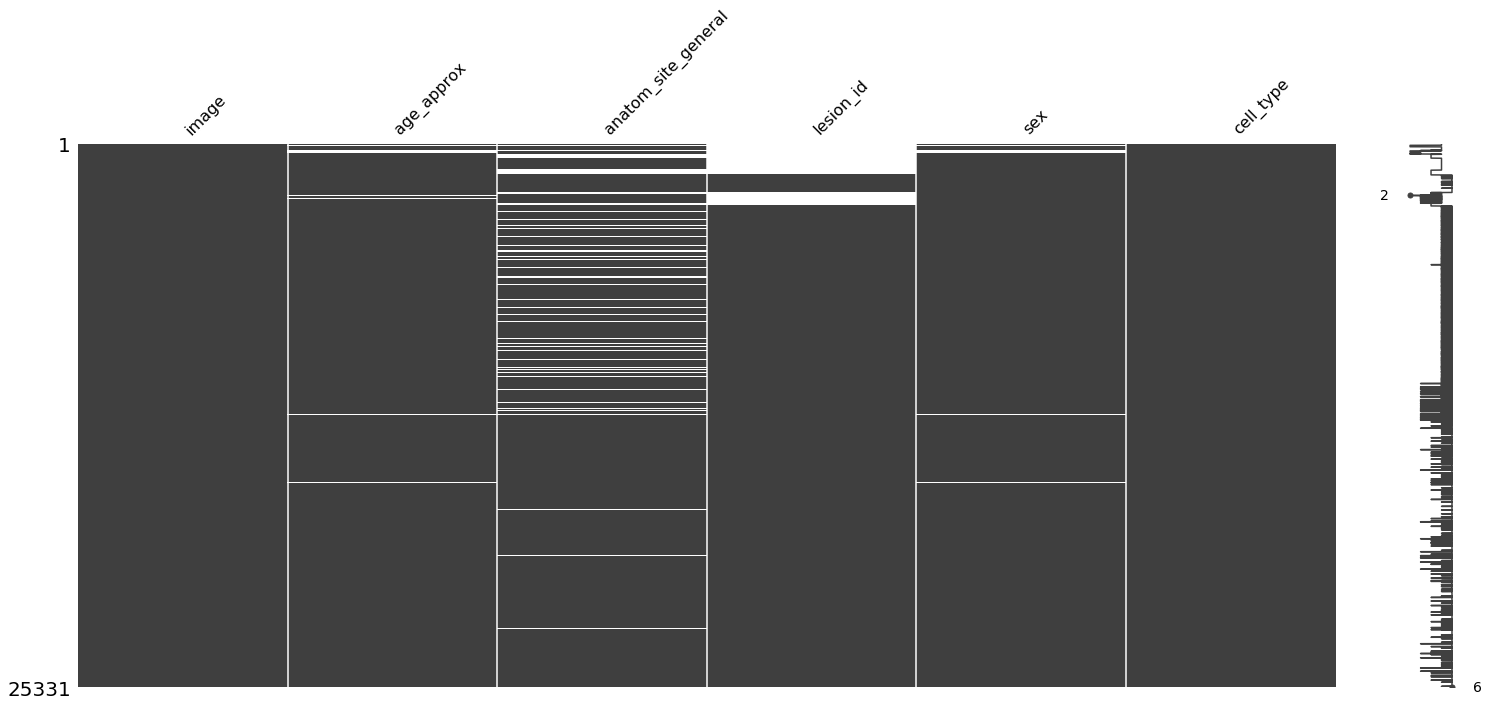

In [12]:
# Create nullity matrix for missing values 
msno.matrix(raw_df)

__Observation__: There appears to be a pattern between age_approx and sex in terms of missing data. 

We will do the following to deal with missing values:
 1. drop lesion_id 
 2. impute age_approx by mean 
 3. impute anatom_site_general and sex by mode

In [14]:
# Check for unique lesion_id
raw_df.lesion_id.nunique()

11847

In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 6 columns):
image                  25331 non-null object
age_approx             24894 non-null float64
anatom_site_general    22700 non-null object
lesion_id              23247 non-null object
sex                    24947 non-null object
cell_type              25331 non-null object
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


In [19]:
# Drop lesion_id 
df = raw_df.loc[:,['image','age_approx','anatom_site_general','sex','cell_type']]

In [20]:
# Impute age_approx by mean 
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)

In [21]:
# Impute by mode 
cols = ['anatom_site_general','sex']
df[cols] = df[cols].fillna(df.mode().iloc[0])

In [22]:
# Check for missing values 
missing_values_table(df)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Before we perform EDA, let's create new cell_type columns to increase intereptability for graphing. 

In [23]:
df.cell_type.value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: cell_type, dtype: int64

In [24]:
# Create dictionary of lesion type 
lesion_type = {'NV': 'Melanocytic nevus','MEL': 'Melanoma','BKL': 'Benign keratosis',
               'BCC': 'Basal cell carcinoma','AK': 'Actinic keratosis','VASC': 'Vascular lesions',
               'DF': 'Dermatofibroma','SCC': 'Squamous cell carcinoma','UNK': 'None of the others'}

In [26]:
# Create new cell_type columns 
df['cell_name'] = df['cell_type'].map(lesion_type.get)

In [27]:
df.head()

,image,age_approx,anatom_site_general,sex,cell_type,cell_name
0,ISIC_0000000,55.0,anterior torso,female,NV,Melanocytic nevus
1,ISIC_0000001,30.0,anterior torso,female,NV,Melanocytic nevus
2,ISIC_0000002,60.0,upper extremity,female,MEL,Melanoma
3,ISIC_0000003,30.0,upper extremity,male,NV,Melanocytic nevus
4,ISIC_0000004,80.0,posterior torso,male,MEL,Melanoma


## Exploratory Data Analysis 

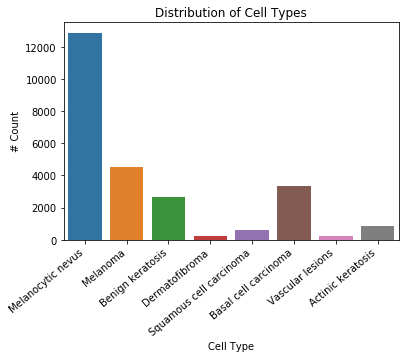

<Figure size 720x504 with 0 Axes>

In [32]:
# Distribution of 9 classes
ax = sns.countplot(x='cell_name', data=df)
ax.set(xlabel='Cell Type', ylabel='# Count')
ax.set_title('Distribution of Cell Types')
plt.figure(figsize=(10,7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


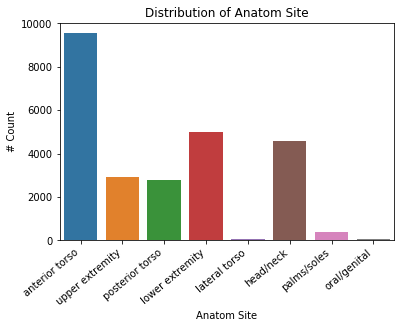

<Figure size 720x504 with 0 Axes>

In [33]:
# Distribution of antom site 
ax = sns.countplot(x='anatom_site_general', data=df)
ax.set(xlabel='Anatom Site', ylabel='# Count')
ax.set_title('Distribution of Anatom Site')
plt.figure(figsize=(10,7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


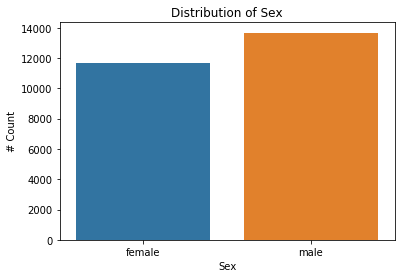

<Figure size 720x504 with 0 Axes>

In [34]:
# Distribution of sex
ax = sns.countplot(x='sex', data=df)
ax.set(xlabel='Sex', ylabel='# Count')
ax.set_title('Distribution of Sex')
plt.figure(figsize=(10,7))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of sex
ax = sns.countplot(x='sex', data=df)
ax.set(xlabel='Sex', ylabel='# Count')
ax.set_title('Distribution of Sex')
plt.figure(figsize=(10,7))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

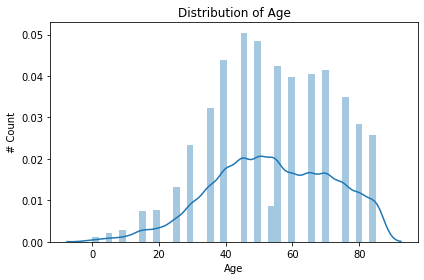

In [37]:
ax = sns.distplot(df.age_approx)
ax.set(xlabel='Age', ylabel='# Count')
ax.set_title('Distribution of Age')
plt.tight_layout()
plt.show()